In [1]:
import os
import cv2
from PIL import Image
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm

import time
import timeit

C:\Users\aquat\AppData\Local\Temp\ipykernel_2712\321412031.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
import keras
import tensorflow as tf
from keras import layers
from keras.models import Model
from keras.layers import Lambda, concatenate
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D , Conv2D , MaxPooling2D
from keras.layers import  Dropout , BatchNormalization , Dense
from keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from keras.callbacks import Callback , ReduceLROnPlateau , ModelCheckpoint
from sklearn.metrics import cohen_kappa_score, accuracy_score
from keras.losses import categorical_crossentropy as logloss
from keras.metrics import categorical_accuracy

In [3]:
# Loading Dataset

Demented_train = np.load('/CSE499/Dataset/ConvertedDataset/Train_Test/DementedTrain.npy')
Demented_test = np.load('/CSE499/Dataset/ConvertedDataset/Train_Test/DementedTest.npy')

NonDemented_train = np.load('/CSE499/Dataset/ConvertedDataset/Train_Test/NonDementedTrain.npy')                      
NonDemented_test = np.load('/CSE499/Dataset/ConvertedDataset/Train_Test/NonDementedTest.npy')


# Check if the datasets are loaded

if Demented_train.size > 0 and Demented_test.size > 0 and NonDemented_train.size > 0 and NonDemented_test.size > 0:
    print('Dataset Loaded!')
else:
    print('Dataset Load failed!')

Dataset Loaded!


In [4]:
# Shape of our dataset
print(f'Demented Train:',  Demented_train.shape)
print(f'Non_Demented Train',  NonDemented_train.shape)
print(f'Demented Test:',  Demented_test.shape)
print(f'Non_Demented Test',  NonDemented_test.shape)

Demented Train: (2240, 128, 128, 3)
Non_Demented Train (2240, 128, 128, 3)
Demented Test: (960, 128, 128, 3)
Non_Demented Test (960, 128, 128, 3)


In [5]:
dementedTrain_Label = np.zeros(len(Demented_train),dtype=float)
NonDementedTrain_label = np.ones(len(NonDemented_train),dtype=float)
dementedTest_Label = np.zeros(len(Demented_test),dtype=float)
NonDementedTest_label = np.ones(len(NonDemented_test),dtype=float) 

X_train = np.concatenate((Demented_train, NonDemented_train), axis = 0)
Y_train = np.concatenate((dementedTrain_Label, NonDementedTrain_label), axis = 0)
X_test = np.concatenate((Demented_test, NonDemented_test), axis = 0)
Y_test = np.concatenate((dementedTest_Label, NonDementedTest_label), axis = 0)

s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

In [6]:
print(f'X train shape:',X_train.shape)
print(f'X test shape:',X_test.shape)
print(f'Y train shape:',Y_train.shape)
print(f'Y test shape:',Y_test.shape)

X train shape: (4480, 128, 128, 3)
X test shape: (1920, 128, 128, 3)
Y train shape: (4480, 2)
Y test shape: (1920, 2)


In [7]:
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=10)

In [8]:
print(f'x train shape:',x_train.shape)
print(f'x val shape:',x_val.shape)
print(f'y train shape:',y_train.shape)
print(f'y val shape:',y_val.shape)

x train shape: (3584, 128, 128, 3)
x val shape: (896, 128, 128, 3)
y train shape: (3584, 2)
y val shape: (896, 2)


In [9]:
# Teacher model with ResNet50
def build_model(backbone , lr = 1e-4):
  model = Sequential()
  model.add(backbone)
  model.add(layers.GlobalAveragePooling2D())
  model.add(layers.Dropout(0.5))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(2 , activation='softmax'))
  
  model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=1e-4),
        metrics=['accuracy']
    )
    
  return model

resnet = ResNet50(
    weights = 'imagenet',
    include_top = False,
    input_shape = (128 , 128 , 3)
)
# call the model 
model = build_model(resnet , lr = 1e-4)
model.build((None, 128, 128, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23,600,002
Trainable params: 23,542,786
No

In [10]:
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,verbose=1,factor=0.2, min_lr=1e-4)
filepath="ResNet50weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [12]:
# Training the teacher model with Resnet50
# Train the teacher model as usual
# Configuration
import time
epochs = 7
batch_size = 64

# Calculate the starting time    
start_time = time.time()

teacher_his = model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_data=(x_val, y_val),
            callbacks=[learn_control, checkpoint])


end_time = time.time()
print("--- Time taken to train : %s seconds ---" % ((end_time - start_time)))

Epoch 1/7
56/56 [==============================] - 323s 6s/step - loss: 0.5720 - accuracy: 0.7584 - val_loss: 1.0348 - val_accuracy: 0.5480 - lr: 1.0000e-04
Epoch 2/7
56/56 [==============================] - 318s 6s/step - loss: 0.2337 - accuracy: 0.8998 - val_loss: 0.6854 - val_accuracy: 0.7065 - lr: 1.0000e-04
Epoch 3/7
56/56 [==============================] - 312s 6s/step - loss: 0.0970 - accuracy: 0.9634 - val_loss: 0.5752 - val_accuracy: 0.7824 - lr: 1.0000e-04
Epoch 4/7
56/56 [==============================] - 305s 5s/step - loss: 0.0373 - accuracy: 0.9874 - val_loss: 0.4507 - val_accuracy: 0.8214 - lr: 1.0000e-04
Epoch 5/7
56/56 [==============================] - 304s 5s/step - loss: 0.0296 - accuracy: 0.9905 - val_loss: 0.6713 - val_accuracy: 0.8225 - lr: 1.0000e-04
Epoch 6/7
56/56 [==============================] - 305s 5s/step - loss: 0.0325 - accuracy: 0.9886 - val_loss: 0.6703 - val_accuracy: 0.7991 - lr: 1.0000e-04
Epoch 7/7
56/56 [==============================] - 304s 5s

In [13]:
model.save_weights("ResNet50_model.h5") #using h5 extension
print("model saved!!!")

model saved!!!


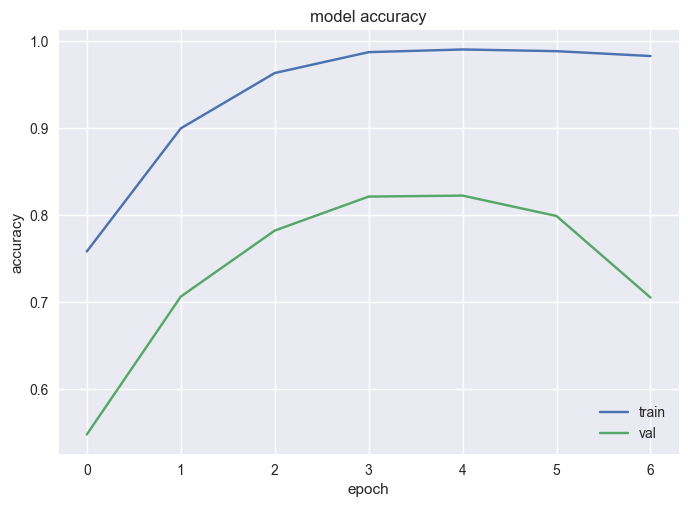

In [14]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(teacher_his.history['accuracy'],)
plt.plot(teacher_his.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

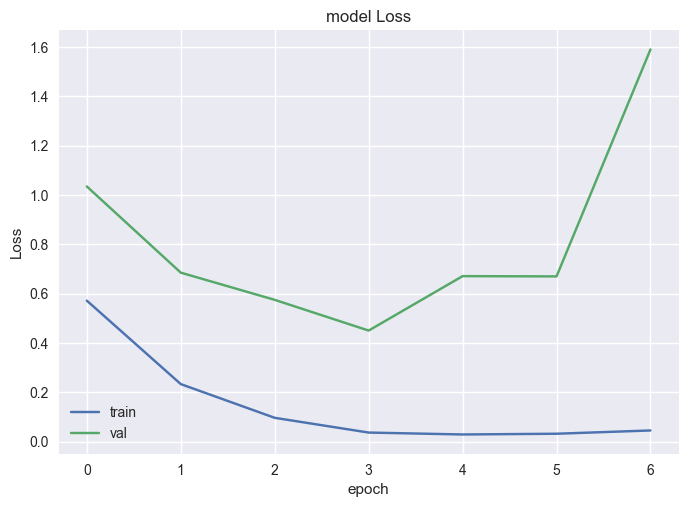

In [15]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(teacher_his.history['loss'])
plt.plot(teacher_his.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower left')
plt.show()

In [16]:
Y_val_pred = model.predict(x_val)
print('The Teacher model Accuracy on the Validation Set:',accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1)))

28/28 [==============================] - 18s 593ms/step
The Teacher model Accuracy on the Validation Set: 0.7053571428571429


In [17]:
#Now let's check my Y_test values
print(f'My Y_test values are:\n' ,Y_test)

My Y_test values are:
 [[1. 0.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [18]:
#Now let's check my predcited values from X_test dataset	
# And calculate the y_pred with time
import timeit

start = timeit.default_timer()
#Your statements here
y_pred = model.predict(X_test)
print(f'My predicted Y_test values are:\n' ,y_pred)

stop = timeit.default_timer()
print('\nTime: ',stop - start,'sec')

60/60 [==============================] - 35s 591ms/step
My predicted Y_test values are:
 [[8.9272363e-03 9.9107271e-01]
 [1.4028070e-03 9.9859720e-01]
 [1.6139163e-07 9.9999988e-01]
 ...
 [7.3881994e-04 9.9926120e-01]
 [5.5667911e-06 9.9999440e-01]
 [2.0021632e-07 9.9999976e-01]]

Time:  35.54360540000198 sec


In [19]:
start = timeit.default_timer()
#Your statements here

#Now let's check the accuracy between the original & predicted (Y_test , y_pred)
print(f'My accuracy on Teacher model with ResNet50 on the Test set is:',accuracy_score(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1)))

stop = timeit.default_timer()
print('\nTime: ',stop - start,'sec')

My accuracy on Teacher model with ResNet50 on the Test set is: 0.6932291666666667

Time:  0.0011172999948030338 sec


In [20]:
# Classification_report
print('Classification Report of Resnet50:\n',classification_report(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1)))

Classification Report of Resnet50:
               precision    recall  f1-score   support

           0       0.96      0.41      0.57       960
           1       0.62      0.98      0.76       960

    accuracy                           0.69      1920
   macro avg       0.79      0.69      0.67      1920
weighted avg       0.79      0.69      0.67      1920



AUC ROC

Auc Curve on Validation:



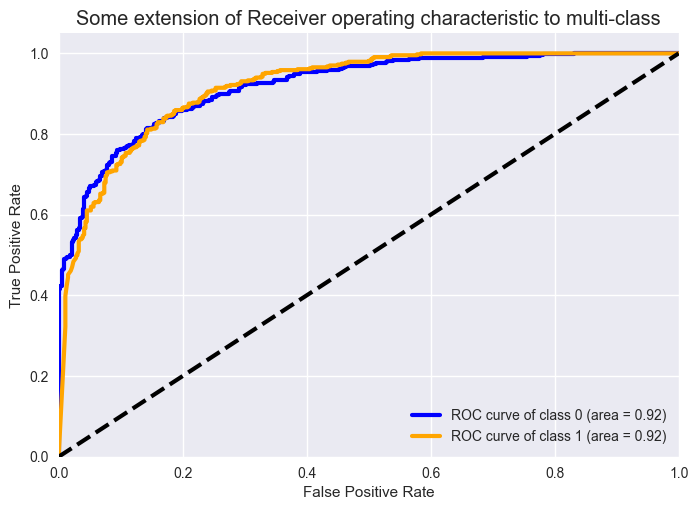

In [21]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

from sklearn.metrics import roc_curve, auc
from numpy import interp
from itertools import cycle

num_of_classes = y_train.shape[1]
print(f'Auc Curve on Validation:\n')


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_of_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], Y_val_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val.ravel(), Y_val_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


lw = 3
# Plot all ROC curves

colors = cycle(['blue', 'orange', 'cornflowerblue'])
for i, color in zip(range(num_of_classes), colors):
    plt.plot(fpr[i],tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    
plt.style.use('ggplot')
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

Auc Curve on Test set:



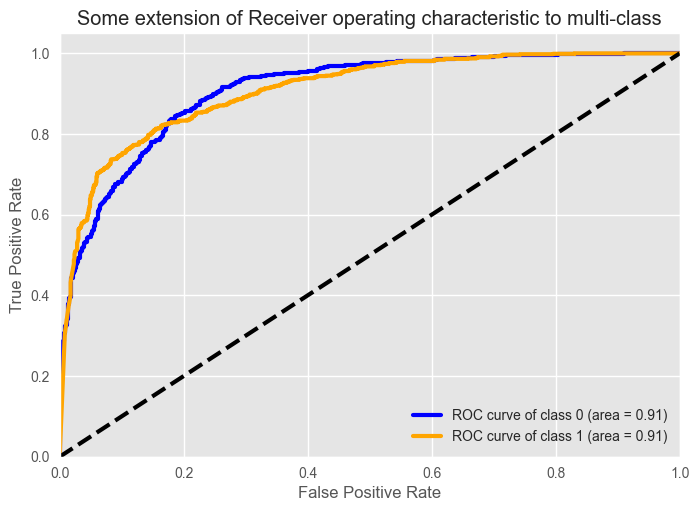

In [22]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

from sklearn.metrics import roc_curve, auc
from numpy import interp
from itertools import cycle

num_of_classes = y_train.shape[1]
print(f'Auc Curve on Test set:\n')


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_of_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


lw = 3
# Plot all ROC curves

colors = cycle(['blue', 'orange', 'cornflowerblue'])
for i, color in zip(range(num_of_classes), colors):
    plt.plot(fpr[i],tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    
plt.style.use('ggplot')
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

Student Model

In [23]:
# Define the student model
# Student model that is stand-alone. We will evaluate its accuracy compared to a teacher trained student model
# Hyperparameters
input_shape = (128, 128, 3) # Input shape of each image
nb_classes = 2 

customstudent = Sequential()
customstudent.add(Conv2D(128, kernel_size=(3, 3),activation='relu', input_shape=input_shape))
customstudent.add(MaxPooling2D(pool_size=(2, 2)))
customstudent.add(Conv2D(64, (3, 3), activation='relu'))
customstudent.add(MaxPooling2D(pool_size=(2, 2)))
customstudent.add(Conv2D(32, (3, 3), activation='relu'))
customstudent.add(Dropout(0.25)) # For reguralization

customstudent.add(layers.Flatten())

customstudent.add(layers.Dense(nb_classes))
customstudent.add(layers.Activation('softmax')) # Note that we add a normal softmax layer to begin with


customstudent.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

print(customstudent.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        18464     
                                                                 
 dropout_1 (Dropout)         (None, 28, 28, 32)       

In [24]:
# Define a new model that outputs only teacher logits
# Raise the temperature of teacher model and gather the soft targets

# Collect the logits from the previous layer output and store it in a different model
teacher_WO_Softmax = Model(model.input, model.get_layer('dense').output)

In [25]:
# Define a manual softmax function
def softmax(x):
    return np.exp(x)/(np.exp(x).sum())

In [26]:
# Prepare the soft targets and the target data for student to be trained upon
# From our temperature experiment we get temp = 10 is gave is best results
temp = 2
# This model directly gives the logits ( see the teacher_WO_softmax model above)
teacher_train_logits = teacher_WO_Softmax.predict(x_train)
teacher_test_logits = teacher_WO_Softmax.predict(x_val) 

# Perform a manual softmax at raised temperature
train_logits_T = teacher_train_logits/ temp # temp = 10
test_logits_T = teacher_test_logits / temp 

Y_train_soft = softmax(train_logits_T)
Y_test_soft = softmax(test_logits_T)

# Concatenate 
Y_train_new = np.concatenate([y_train, Y_train_soft], axis=1)
Y_test_new =  np.concatenate([y_val, Y_test_soft], axis =1)

#Print the Shape 
print(train_logits_T.shape)
print(test_logits_T.shape)
print(Y_train_new.shape)
print(Y_test_new.shape)

28/28 [==============================] - 16s 585ms/step
(3584, 2)
(896, 2)
(3584, 4)
(896, 4)


In [27]:
# Prepare the student model that outputs probabilities with and without temperature
# Remove the softmax layer from the student network
temp = 2
customstudent.layers.pop()

# Now collect the logits from the last layer
# This is going to be a tensor. And hence it needs to pass through a Activation layer
logits = customstudent.layers[-1].output 
probs = layers.Activation('softmax')(logits)


# softed probabilities at raised temperature
logits_T = Lambda(lambda x: x / temp)(logits)
probs_T = layers.Activation('softmax')(logits_T)

output = concatenate([probs, probs_T])

# This is our new student model 
customstudent = Model(customstudent.input, output)

customstudent.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 conv2d_input (InputLayer)      [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 126, 126, 12  3584        ['conv2d_input[0][0]']           
                                8)                                                                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 63, 63, 128)  0           ['conv2d[0][0]']                 
                                                                                            

In [28]:
# Declare knowledge distillation loss function
# This will be a teacher trained student model. 
# This uses a knowledge distillation loss function
# Declare knowledge distillation loss
def knowledge_distillation_loss(y_true, y_pred, alpha):

    # Extract the one-hot encoded values and the softs separately so that we can create two objective functions
    y_true, y_true_softs = y_true[: , :nb_classes], y_true[: , nb_classes:]
    
    y_pred, y_pred_softs = y_pred[: , :nb_classes], y_pred[: , nb_classes:]
    
    loss = alpha*logloss(y_true,y_pred) + (1-alpha)*logloss(y_true_softs, y_pred_softs)
    
    return loss

# For testing use regular output probabilities - without temperature
def acc(y_true, y_pred):
    y_true = y_true[:, :nb_classes]
    y_pred = y_pred[:, :nb_classes]
    return categorical_accuracy(y_true, y_pred)

customstudent.compile(
    #optimizer=optimizers.SGD(lr=1e-1, momentum=0.9, nesterov=True),
    optimizer='adadelta',
    loss=lambda y_true, y_pred: knowledge_distillation_loss(y_true, y_pred, 0.1),
    #loss='categorical_crossentropy',
    metrics=[acc] 
  )

In [29]:
# Train the student model
epochs = 15
batch_size = 64
customstudent_student_his = customstudent.fit(x_train, Y_train_new,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_val, Y_test_new))

Epoch 1/15
56/56 [==============================] - 89s 2s/step - loss: 0.0799 - acc: 0.5086 - val_loss: 0.0838 - val_acc: 0.4799
Epoch 2/15
56/56 [==============================] - 88s 2s/step - loss: 0.0810 - acc: 0.4992 - val_loss: 0.0832 - val_acc: 0.4866
Epoch 3/15
56/56 [==============================] - 88s 2s/step - loss: 0.0791 - acc: 0.5170 - val_loss: 0.0826 - val_acc: 0.4888
Epoch 4/15
56/56 [==============================] - 88s 2s/step - loss: 0.0810 - acc: 0.4969 - val_loss: 0.0823 - val_acc: 0.4922
Epoch 5/15
56/56 [==============================] - 88s 2s/step - loss: 0.0800 - acc: 0.5078 - val_loss: 0.0818 - val_acc: 0.4911
Epoch 6/15
56/56 [==============================] - 88s 2s/step - loss: 0.0798 - acc: 0.5084 - val_loss: 0.0800 - val_acc: 0.5011
Epoch 7/15
56/56 [==============================] - 88s 2s/step - loss: 0.0791 - acc: 0.5148 - val_loss: 0.0795 - val_acc: 0.5100
Epoch 8/15
56/56 [==============================] - 88s 2s/step - loss: 0.0798 - acc: 0.50

C:\Users\aquat\AppData\Local\Temp\ipykernel_2712\2520390268.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


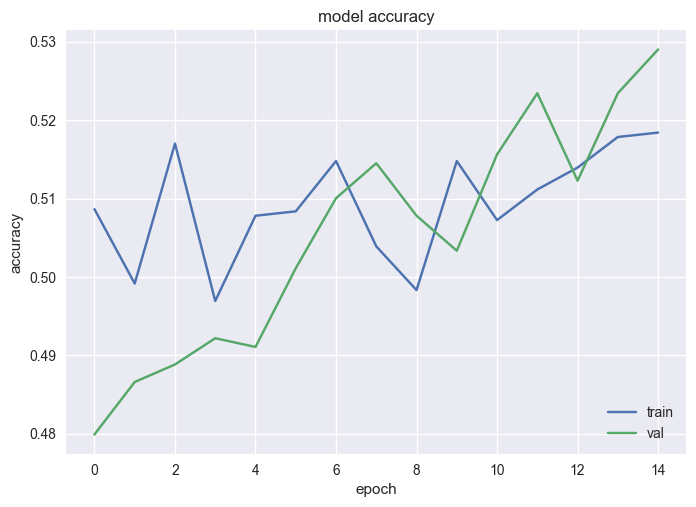

In [30]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.style.use('seaborn')
plt.plot(customstudent_student_his.history['acc'])
plt.plot(customstudent_student_his.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

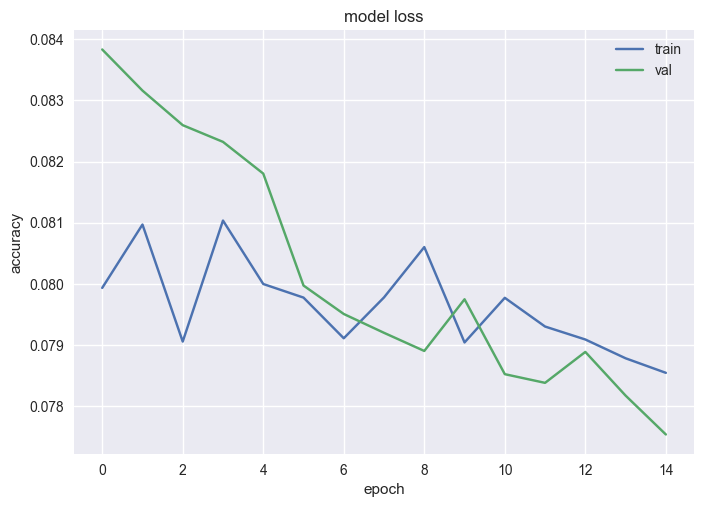

In [31]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(customstudent_student_his.history['loss'])
plt.plot(customstudent_student_his.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [32]:
Y_val_pred_student = customstudent.predict(x_val)
print(f'The CustomStudent model Accuracy on the Validation Set:',accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred_student, axis=1)))

28/28 [==============================] - 5s 187ms/step
The CustomStudent model Accuracy on the Validation Set: 0.5290178571428571


In [33]:
#Now let's check my Y_test values
print(f'My Y_test values are:\n' ,Y_test)

My Y_test values are:
 [[1. 0.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [34]:
#Now let's check my predcited values from X_test dataset	
import timeit

start = timeit.default_timer()
#Your statements here
y_pred_student = customstudent.predict(X_test)
print(f'My predicted Y_test values are:\n' ,y_pred_student)

stop = timeit.default_timer()
print('\nTime: ',stop - start,'sec')

60/60 [==============================] - 11s 189ms/step
My predicted Y_test values are:
 [[0.26895213 0.7310479  0.37754706 0.622453  ]
 [0.66979605 0.33020398 0.5874979  0.4125021 ]
 [0.26894197 0.7310581  0.37754098 0.62245905]
 ...
 [0.37325633 0.6267437  0.43557608 0.5644239 ]
 [0.26894143 0.7310586  0.37754068 0.62245935]
 [0.26905105 0.7309489  0.37760615 0.62239385]]

Time:  11.40543759999855 sec


In [35]:
start = timeit.default_timer()
#Your statements here

#Now let's check the accuracy between the original & predicted (Y_test , y_pred)
print(f'My accuracy on Custom Student model on the Test set is:',accuracy_score(np.argmax(Y_test, axis=1), np.argmax(y_pred_student, axis=1)))

stop = timeit.default_timer()
print('\nTime: ',stop - start,'sec')

My accuracy on Custom Student model on the Test set is: 0.51875

Time:  0.0012700999941444024 sec


In [36]:
# Classification_report
print(f'Classification Report of Resnet50:\n',classification_report(np.argmax(Y_test, axis=1), np.argmax(y_pred_student, axis=1)))

Classification Report of Resnet50:
               precision    recall  f1-score   support

           0       0.54      0.24      0.34       960
           1       0.51      0.79      0.62       960

    accuracy                           0.52      1920
   macro avg       0.53      0.52      0.48      1920
weighted avg       0.53      0.52      0.48      1920



Auc Curve on Validation:



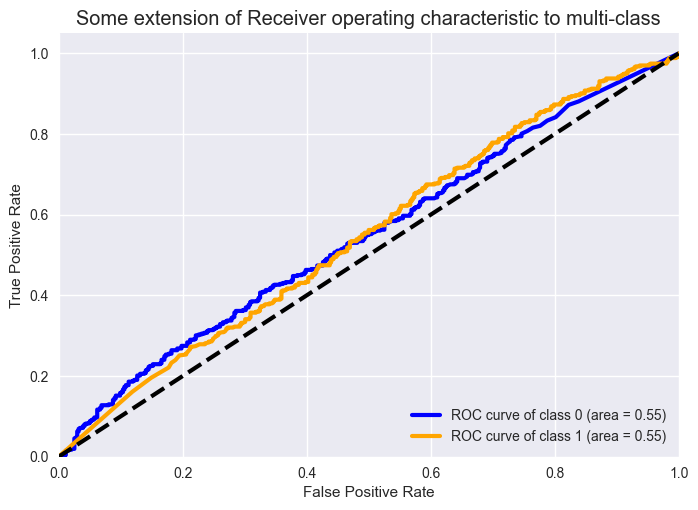

In [37]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

from sklearn.metrics import roc_curve, auc
from numpy import interp
from itertools import cycle

num_of_classes = y_train.shape[1]
print(f'Auc Curve on Validation:\n')


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_of_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_new[:, i], Y_val_pred_student[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
# fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_new.ravel(), Y_val_pred_student.ravel())
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


lw = 3
# Plot all ROC curves

colors = cycle(['blue', 'orange', 'cornflowerblue'])
for i, color in zip(range(num_of_classes), colors):
    plt.plot(fpr[i],tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    
plt.style.use('ggplot')
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

Auc Curve on Test set:



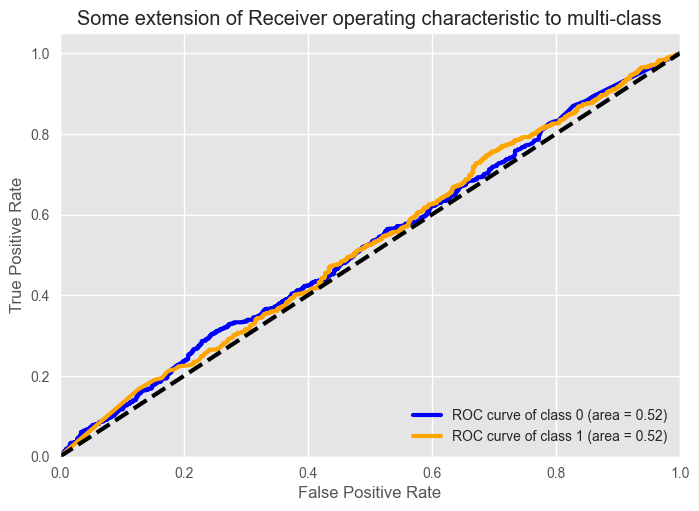

In [38]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

from sklearn.metrics import roc_curve, auc
from numpy import interp
from itertools import cycle

num_of_classes = y_train.shape[1]
print(f'Auc Curve on Test set:\n')


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_of_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], y_pred_student[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
# fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), y_pred_student.ravel())
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


lw = 3
# Plot all ROC curves

colors = cycle(['blue', 'orange', 'cornflowerblue'])
for i, color in zip(range(num_of_classes), colors):
    plt.plot(fpr[i],tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    
plt.style.use('ggplot')
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()